<a href="https://colab.research.google.com/github/Iwillnottellyou/Stein-importance-weighted-beta-SVGD/blob/main/highdim_stein_svgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


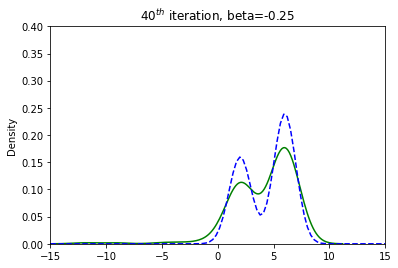

In [175]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform


def mirror_descent_heavy_ball(A,iter,stepsize,omega,alpha):
    iter= iter
    stepsize=stepsize
    omega_m = omega
    omegaold = omega
    n = omega.shape[0]
    for j in range(iter):
        omega_m = omegaold
        omegaold = omega
        for i in range(n):
          omega[i]=omega[i]*np.exp(-stepsize*np.matmul(A[i],omegaold)+alpha*(omegaold[i]-omega_m[i]))
        omega = (1/omega.sum())*omega 
    #print(omega)

    return omega 

def mirror_descent_momentum(A,iter,stepsize,omega,alpha):
    iter= iter
    stepsize=stepsize
    omega_m = omega
    n = omega.shape[0]
    for j in range(iter):
        omega_m = alpha*omega_m + np.matmul(A,omega)
        for i in range(n):
          omega[i]=omega[i]*np.exp(-stepsize*omega_m[i])
        omega = (1/omega.sum())*omega 
    #print(np.matmul(np.matmul(A,omega),omega),sum(i>0.01 for i in n*omega)/n)

    return omega 

class SVGD_model():

    def __init__(self):
        pass


    def SVGD_kernal(self, x,beta, h=-1):
        init_dist = pdist(x)
        pairwise_dists = squareform(init_dist)
        if h < 0:  # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = h ** 2 / np.log(x.shape[0] + 1)

        kernal_xj_xi = np.exp(- pairwise_dists ** 2 / h)/ (np.sqrt( np.pi * h))

        d_kernal_xi = np.zeros(x.shape)
        for i_index in range(x.shape[0]):
            d_kernal_xi[i_index] = np.matmul(kernal_xj_xi[i_index], x[i_index] - x) * 2 / (np.sqrt( np.pi * h)*h)

        return kernal_xj_xi, d_kernal_xi



    def update(self, x0, lnprob,probdensity,beta, n_iter=1000, stepsize=1e-3,opt_step = 1,opt_iter=20, bandwidth=-1, debug=False,alpha=0.5,optimization_choice=2):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')

        x = np.copy(x0)
        n = x.shape[0]
        omega = 1/n*np.ones(n)
        # adagrad with momentum
        eps_factor = 1e-8
        historical_grad_square = 0
        for iter in range(n_iter):
            if debug and (iter + 1) % 1000 == 0:
                print('iter ' + str(iter + 1))
            gradmatrix = lnprob(x)

            if beta==0:
              kernal_xj_xi, d_kernal_xi = self.SVGD_kernal(x,0, bandwidth)
              current_grad = (np.matmul(kernal_xj_xi, gradmatrix) + d_kernal_xi) / n
              x += stepsize * current_grad
            else:
              kernal_xj_xi, d_kernal_xi = self.SVGD_kernal(x,beta, bandwidth)

              SteinMatrix = np.multiply(kernal_xj_xi,np.matmul(gradmatrix,gradmatrix.transpose()))
              #+dd_kernal_xj_xi+np.matmul(np.diag(gradmatrix.transpose()[0]),d_kernal_xj_xi)+np.matmul(d_kernal_xj_xi.transpose(),np.diag(gradmatrix.transpose()[0]))
 
              if optimization_choice == 1:
                omega = mirror_descent_heavy_ball(SteinMatrix,opt_iter,opt_step,omega,alpha) 
              if optimization_choice == 2:
                omega = mirror_descent_momentum(SteinMatrix,opt_iter,opt_step,omega,alpha) 

              current_grad = np.multiply(np.mat((n*omega+0.0001)**(beta)).transpose(),(np.matmul(kernal_xj_xi, gradmatrix) + d_kernal_xi)) / n
              x += stepsize * current_grad
        return x



sns.set_palette('deep', desat=.6)
sns.set_context(rc={'figure.figsize': (8, 5) } )

class OneDimensionGM():

    def __init__(self, omega, mean, var):
        self.omega = omega
        self.mean = mean
        self.var = var

    def dlnprob(self, x):
        rep_x = np.matlib.repmat(x, 1, self.omega.shape[0])
        category_prob = np.exp(- (rep_x - self.mean) ** 2 / (2 * self.var)) / (np.sqrt(2 * np.pi * self.var)) * self.omega
        den = np.sum(category_prob, 1)
        num = ((- (rep_x - self.mean) / self.var) * category_prob).sum(1)
        return np.expand_dims((num / den), 1)

    def MGprob(self, x):
        rep_x = np.matlib.repmat(x, 1, self.omega.shape[0])
        category_prob = np.exp(- (rep_x - self.mean) ** 2 / (2 * self.var)) / (np.sqrt(2 * np.pi * self.var)) * self.omega
        den = np.sum(category_prob, 1)
        return np.expand_dims(den, 1)

class highDimensionGM():

    def __init__(self, dimension,omega, mean, var):
        self.dimension = dimension
        self.omega = omega
        self.mean = mean
        self.var = var

    def dlnprob(self, x):
        rep_x = np.tile(x,(1,w.shape[0],1))
        category_prob = np.exp(- np.linalg.norm(rep_x-self.mean,axis=2)**2 / (2 * self.var)) / ((2 * np.pi * self.var)**(self.dimension/2)) * self.omega
        den = np.expand_dims(np.sum(category_prob, 1),axis=1)
        num = ((- (rep_x - self.mean) / self.var)*np.expand_dims(category_prob,axis=2) ).sum(1)

        return num/den

    def MGprob(self, x):
        rep_x = np.tile(x,(1,w.shape[0],1))
        category_prob = np.exp(- np.linalg.norm(rep_x-self.mean,axis=2)**2 / (2 * self.var)) / ((2 * np.pi * self.var)**(self.dimension/2)) * self.omega
        den = np.sum(category_prob,1)
        return np.expand_dims(den,1)

if __name__ == "__main__":

    dimension = 2
    w = np.array([0.4,0.6])
    mean = np.array([[2,0],[6,0]])
    var = np.array([1,1])

    highDimensionGM_model = highDimensionGM(dimension,w, mean, var)

    np.random.seed(0)
    num_particle = 2
    x0 = np.random.normal(0, 2, [num_particle,1, dimension]);
    dlnprob = highDimensionGM_model.dlnprob
    probdensity=highDimensionGM_model.MGprob

    svgd_model = SVGD_model()
    n_iter = 40
    beta =-0.25
   
    x = svgd_model.update(x0, dlnprob, probdensity, beta, n_iter=n_iter, stepsize=0.9,opt_step = 5, opt_iter=20, bandwidth=-1, debug=True,alpha=0.2,optimization_choice=2)
    #biggest stepsize=1.9

    #plot result
    sns.kdeplot(x.reshape((num_particle,)), bw = .4, color = 'g')

    mg_prob = OneDimensionGM_model.MGprob
    x_lin = np.expand_dims(np.linspace(-15, 15, 100), 1)
    x_prob = mg_prob(x_lin)
    plt.plot(x_lin, x_prob, 'b--')
    plt.axis([-15, 15, 0, 0.4])
    plt.title(str(n_iter) + '$ ^{th}$ iteration, '+'beta='+str(beta))
    plt.show()

#iter=20, out_stepsize=0.5, inner_stepsize=5,inner_iter=100 achieve very good results.

#iter=500, stepsize=1.1,inner_stepsize=5,inner_iter=20 is stable than 0-SVGD with stepsize=11, \
#while when stepsize=12 for SVGD(it will diverge) and stepsize=1.2 for stein -0.5-SVGD(converge)
#200 particle,when stepsize=1 for stein -0.5-SVGD , 500 iterations,it can produce nice results, but for SVGD with stepsize=10, the result is bad

